# SVM, forêts aléatoires, boosting et régression régularisée
## Partie 1 : Discrimination binaire

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(kernlab)))
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(doParallel)))
suppressWarnings(suppressMessages(library(pROC)))

In [2]:
roclist <- list()
results <- tibble(model = character(), accuracy = double(), auc = double())

Importer le jeu de données `spam` du package `kernlab` à l’aide de la commande `data(spam)`. Afficher les informations sur ce jeu de données à l’aide de la commande `help(spam)`, ainsi qu’un résumé de ce jeu de données.  
Séparer le jeu de données en un échantillon d’apprentissage et un échantillon de validation de son choix.

In [3]:
data(spam)
spam <- spam %>% rename(Y = type)
part <- createDataPartition(spam$Y, p = 2/3)
data_train <- spam[part$Resample1,]
data_test <- spam[-part$Resample1,]

Lancer sur l’échantillon d’apprentissage une SVM linéaire en ajustant sa constante de tolérance C par validation croisée 5-fold.

In [4]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

svm_1 <- caret::train(
    Y~., data = data_train, method = 'svmLinear',
    trControl = trainControl("cv", number = 5, allowParallel = T),
    tuneGrid = expand.grid(C = seq(.001, 1.001, by = .01))
)
on.exit(stopCluster(cl))

In [5]:
results %>% print

# A tibble: 0 x 3
# ... with 3 variables: model <chr>, accuracy <dbl>, auc <dbl>


Setting levels: control = 1, case = 2
Setting direction: controls < cases


Test accuracy: 0.925636007827789 
Test AUC:  0.916054790809744

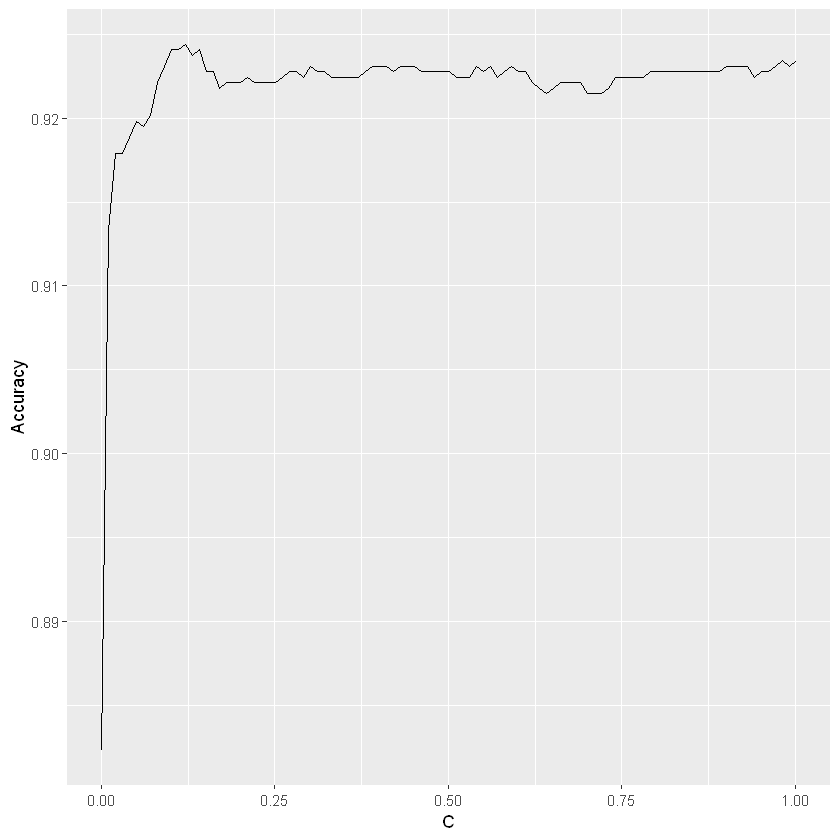

In [6]:
ggplot(svm_1$results) +
aes(C, Accuracy) + geom_line()

test <- pull(data_test, Y) %>% as.numeric
pred <- predict(svm_1$finalModel, newdata = select(data_test, -Y)) %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['svmLinear']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'svmLinear', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Test accuracy:', acc,
    '\nTest AUC: ', rc$auc
))

Lancer sur l’échantillon d’apprentissage une SVM à noyau gaussien (radial) en ajustant ses paramètres par validation croisée 5-fold.

In [7]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

svm_2 <- caret::train(
    Y~., data = data_train, method = 'svmRadial',
    trControl = trainControl("cv", number = 5, allowParallel = T),
    tuneGrid = expand.grid(sigma = seq(0, 1, by = .2), C = seq(.01, 1, by = .01))
)
on.exit(stopCluster(cl))

Setting levels: control = 1, case = 2
Setting direction: controls < cases


Test accuracy: 0.864970645792564 
Test AUC:  0.832117601351592

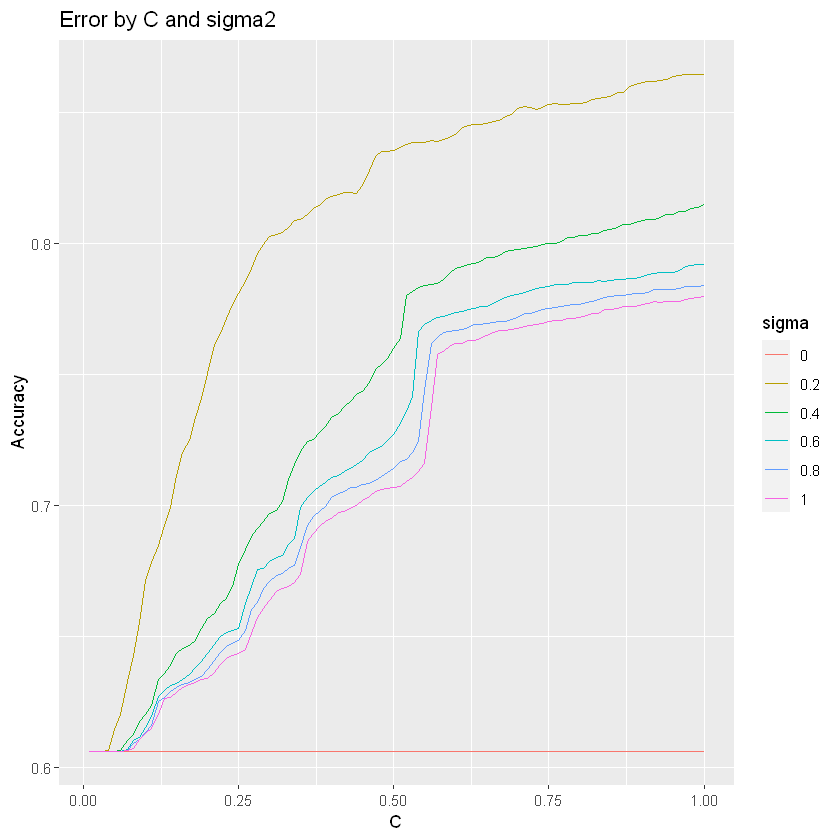

In [8]:
svm_2$results %>% mutate(sigma = as.factor(sigma)) %>% 
ggplot() + aes(x = C, y = Accuracy, color = sigma) + 
geom_line() +
ggtitle('Error by C and sigma2')

pred <- predict(svm_2$finalModel, newdata = select(data_test, -Y)) %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['svmRadial']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'svmRadial', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Test accuracy:', acc,
    '\nTest AUC: ', rc$auc
))

Lancer sur l’échantillon d’apprentissage un algorithme de forêt aléatoire en ajustant ses paramètres par la méthode Out Of Bag.

In [9]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

rf_1 <- caret::train(
    Y~., data = data_train, method = 'ranger', importance = 'impurity_corrected',
    trControl = trainControl(method = "oob", allowParallel = T),
    tuneGrid = expand.grid(
        mtry = seq(1, length(data_train)-1),
        splitrule = "gini", min.node.size = 1
    )
)
on.exit(stopCluster(cl))

Warning message in predict.ranger(rf_1$finalModel, data = select(data_test, -Y)):
"Forest was grown with 'impurity_corrected' variable importance. For prediction it is advised to grow another forest without this importance setting."Setting levels: control = 1, case = 2
Setting direction: controls < cases


Test accuracy: 0.929549902152642 
Test AUC:  0.916388055232786

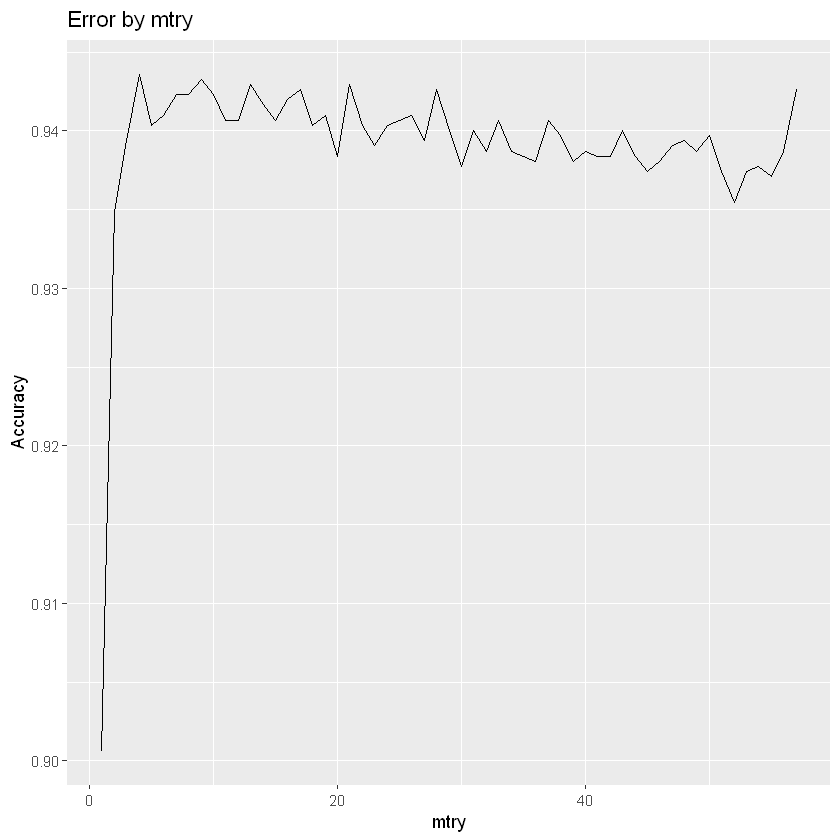

In [10]:
rf_1$results %>% 
ggplot() + aes(x = mtry, y = Accuracy) + 
geom_line() +
ggtitle('Error by mtry')

pred <- predict(rf_1$finalModel, data = select(data_test, -Y))$prediction %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['RF']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'RF', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Test accuracy:', acc,
    '\nTest AUC: ', rc$auc
))

Selecting by importance


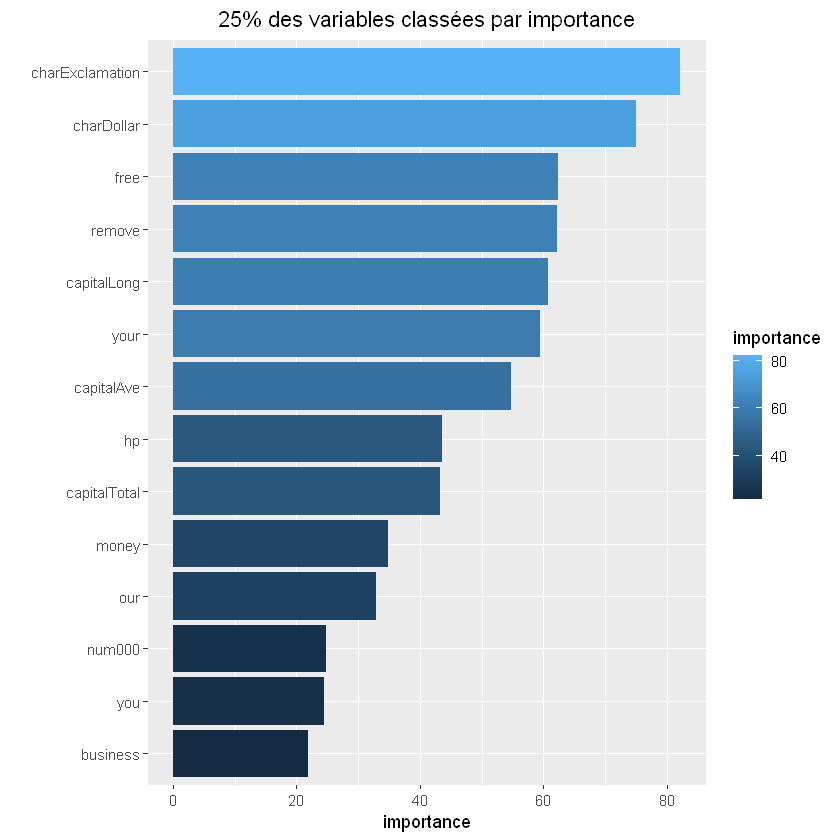

In [11]:
rf_naive_vars <- rf_1$finalModel$variable.importance
rf_naive_vars <- tibble(variable = names(rf_naive_vars), importance = rf_naive_vars) %>% 
    arrange(importance) %>% mutate(variable = factor(variable, levels = variable)) %>% 
    top_frac(0.25)

ggplot(rf_naive_vars) + coord_flip() + 
  aes(x = variable, y = importance, fill = importance) + geom_bar(stat = "identity") + 
  labs(title = "25% des variables classées par importance", x = "") +
  theme(plot.title = element_text(hjust = 0.5))

Lancer sur l’échantillon d’apprentissage des algorithmes de Gradient Boosting (Adaboost et Logitboost), puis un algorithme d’eXtreme Gradient Boosting (XGBoost) en ajustant leurs paramètres par validation croisée 5-fold.

In [12]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

ada_1 <- caret::train(
    Y~., data = data_train, method = 'gbm', distribution = "adaboost",
    trControl = trainControl("cv", number = 5, allowParallel = T),
    tuneGrid = expand.grid(
        n.trees = c(2000, 5000), interaction.depth = 1,
        shrinkage = c(.01, .025, .05,.075,.1),
        n.minobsinnode = 10
    ), verbose = F
)
on.exit(stopCluster(cl))

Setting levels: control = 1, case = 2
Setting direction: controls < cases


Test accuracy: 0.939986953685584 
Test AUC:  0.930501892656777

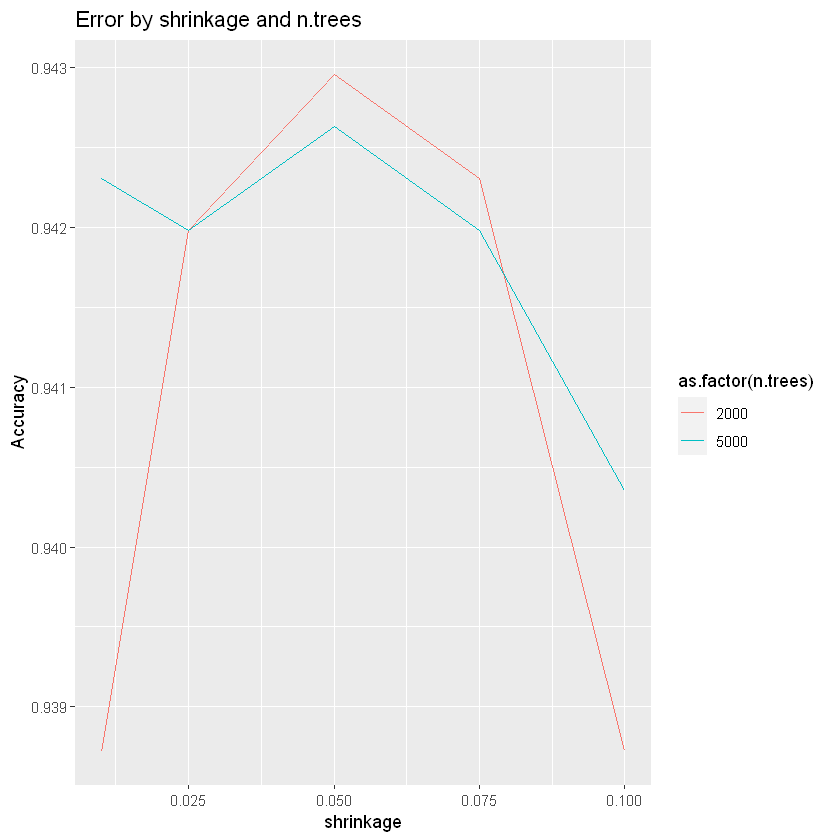

In [13]:
ada_1$results %>%
ggplot() + aes(x = shrinkage, y = Accuracy, color = as.factor(n.trees)) + 
geom_line() +
ggtitle('Error by shrinkage and n.trees')

test <- (data_test$Y == "nonspam") %>% as.factor %>% as.numeric
pred <- (predict(ada_1$finalModel, newdata = select(data_test, -Y), ada_1$finalModel$n.trees) > 0) %>% as.factor %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['adaboost']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'adaboost', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Test accuracy:', acc,
    '\nTest AUC: ', rc$auc
))

In [14]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

logit_1 <- caret::train(
    Y~., data = data_train, method = 'gbm', distribution = "bernoulli",
    trControl = trainControl("cv", number = 5, allowParallel = T),
    tuneGrid = expand.grid(
        n.trees = c(2000, 5000), interaction.depth = 1,
        shrinkage = c(.01, .025, .05,.075,.1, .15),
        n.minobsinnode = 10
    ), verbose = F
)
on.exit(stopCluster(cl))

Setting levels: control = 1, case = 2
Setting direction: controls < cases


Test accuracy: 0.94194390084801 
Test AUC:  0.933274937802522

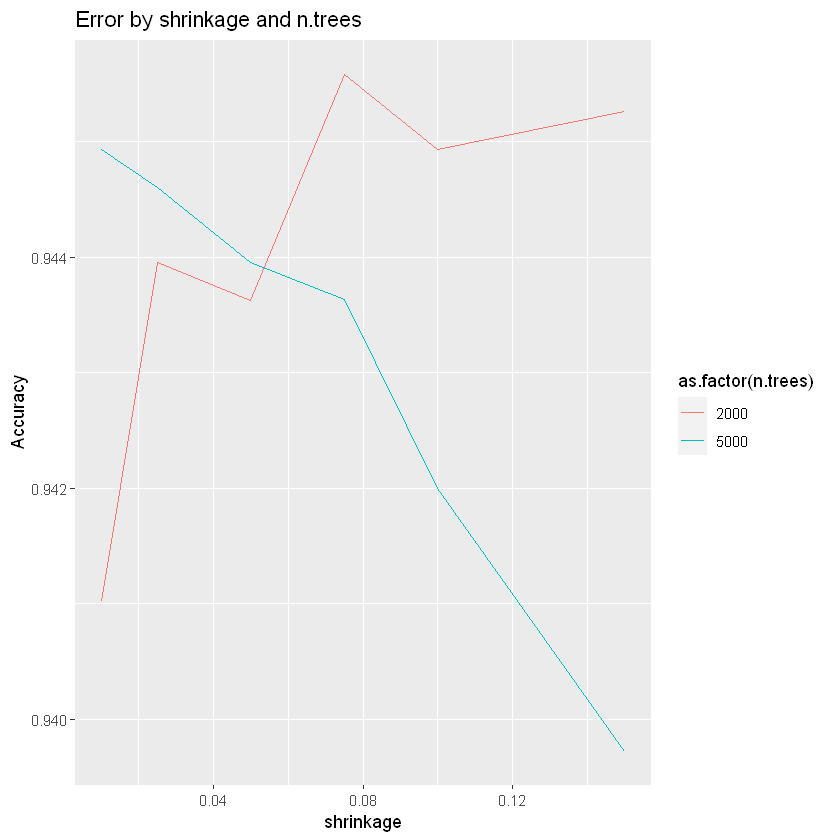

In [15]:
logit_1$results %>%
ggplot() + aes(x = shrinkage, y = Accuracy, color = as.factor(n.trees)) + 
geom_line() +
ggtitle('Error by shrinkage and n.trees')

pred <- (predict(logit_1$finalModel, newdata = select(data_test, -Y), logit_1$finalModel$n.trees) > 0) %>% as.factor %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['logitboost']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'logitboost', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Test accuracy:', acc,
    '\nTest AUC: ', rc$auc
))

In [16]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

xgb_1 <- caret::train(
    Y~., data = data_train, method = 'xgbTree',
    trControl = trainControl("cv", number = 5, allowParallel = T),
    tuneGrid = expand.grid(
        nrounds = seq(1, 100, by=10), eta = c(.025, .05, .1, .2),
        max_depth = c(2,4,6), gamma = c(0, .05, .1, .5, .75, 1),
        colsample_bytree = 1, min_child_weight = 1, subsample = 1
    )
)
on.exit(stopCluster(cl))

Setting levels: control = 1, case = 2
Setting direction: controls < cases


Test accuracy: 0.94781474233529 
Test AUC:  0.94072526892835

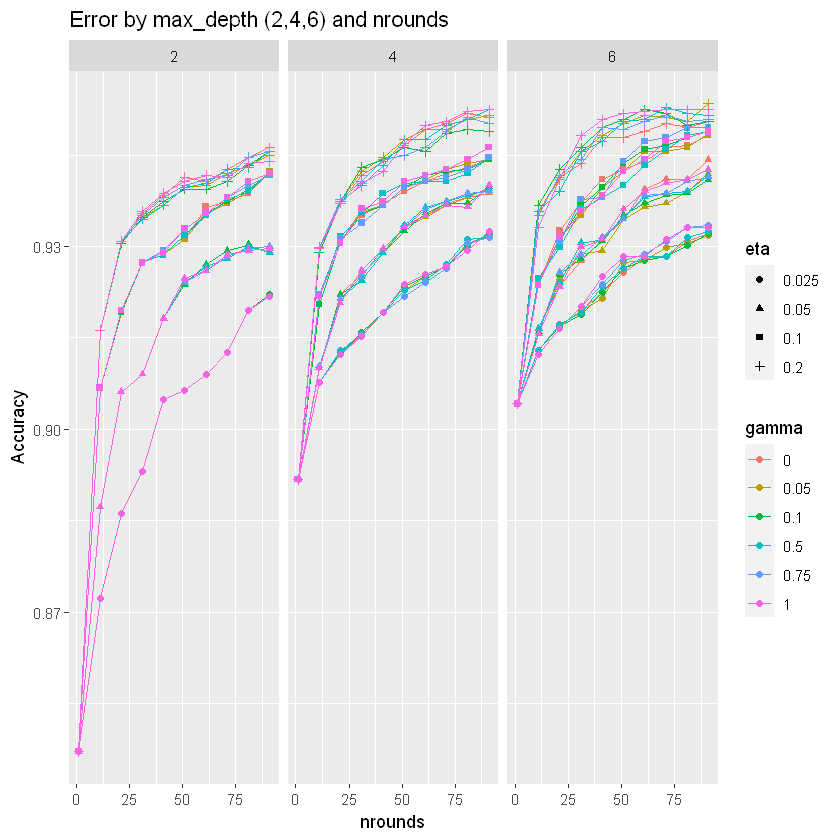

In [17]:
xgb_1$results %>% 
mutate(
    eta = as.factor(eta),
    max_depth = as.factor(max_depth),
    gamma = as.factor(gamma)
) %>% ggplot() + aes(nrounds, Accuracy, color = gamma, shape=eta) +
geom_line() + geom_point() + facet_grid(.~max_depth) +
ggtitle('Error by max_depth (2,4,6) and nrounds')

pred <- (predict(xgb_1$finalModel, newdata = select(data_test, -Y) %>% as.matrix) > .5) %>% as.factor %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['xgboost']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'xgboost', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Test accuracy:', acc,
    '\nTest AUC: ', rc$auc
))

Comparer les performances des différents algorithmes retenus sur l’échantillon de validation.

model,accuracy,auc
svmLinear,0.9256360,0.9160548
svmRadial,0.8649706,0.8321176
RF,0.9295499,0.9163881
adaboost,0.9399870,0.9305019
logitboost,0.9419439,0.9332749
xgboost,0.9478147,0.9407253


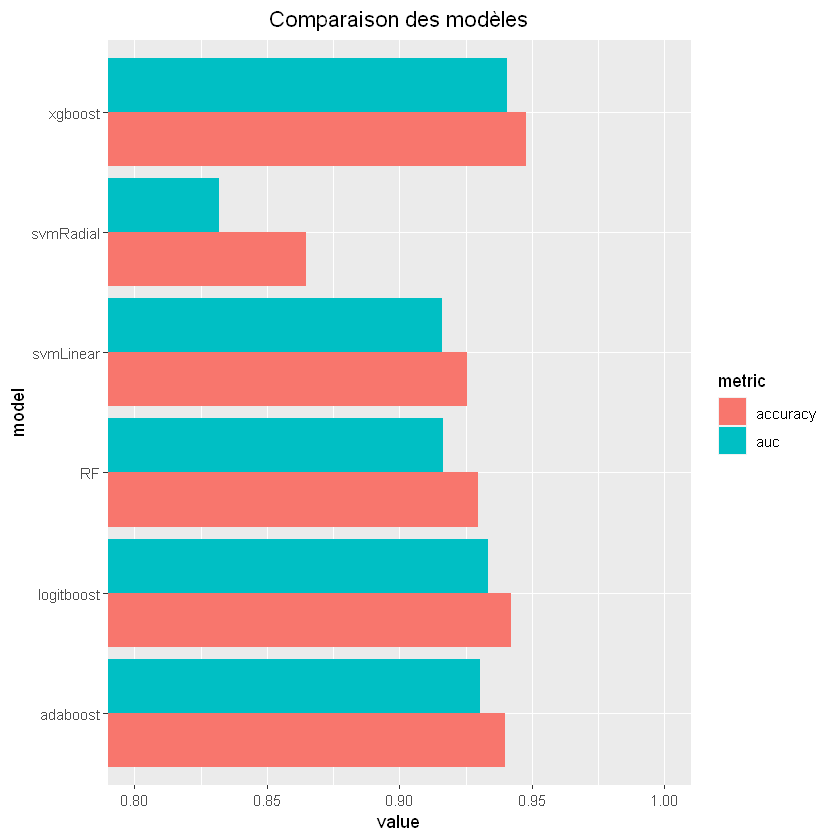

In [18]:
results

results %>% 
gather(metric, value, -model) %>% 
ggplot() +
aes(fill = metric, y = value, x = model) +
geom_bar(position = "dodge", stat = "identity") +
coord_flip(ylim = c(.8, 1)) +
labs(title = "Comparaison des modèles") +
theme(plot.title = element_text(hjust = 0.5))

Tracer les courbes ROC des algorithmes retenus, et les comparer.

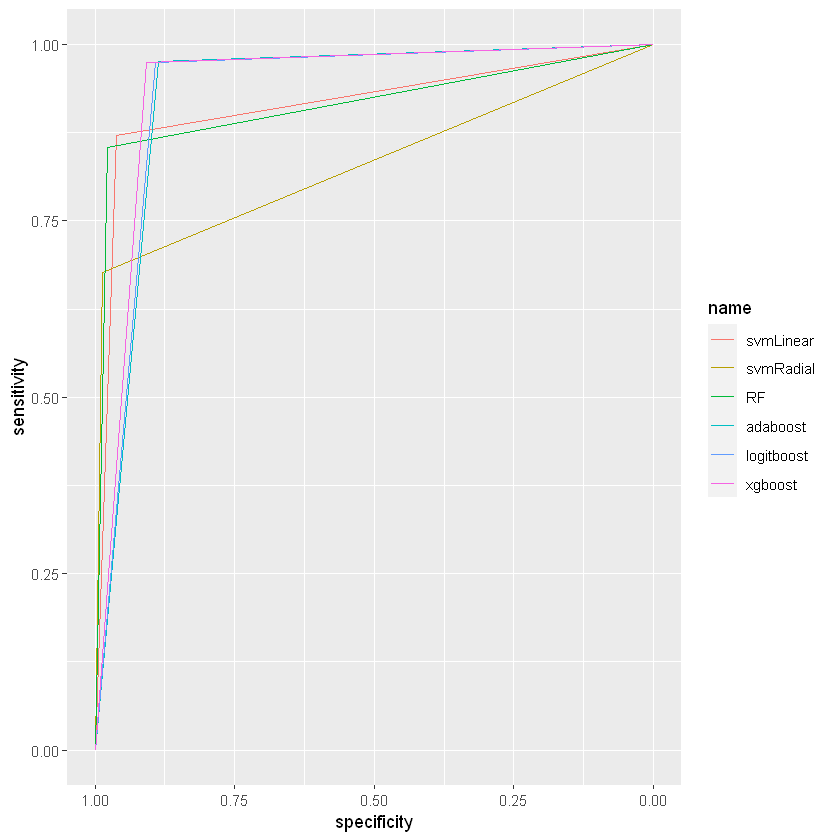

In [19]:
ggroc(roclist)